In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
from DL_Autoencoder import DL_auto as DL

In [3]:




# Define your Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [4]:
class Autoencoder2deeper(nn.Module):
    def __init__(self):
        super(Autoencoder2deeper, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:

class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(16)
        self.dec_conv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = torch.sigmoid(self.dec_conv4(x))

        return x

In [6]:

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)  # Use Sigmoid for normalizing the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, 501))  # adapt to your target size
        return x


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_conv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn4 = nn.BatchNorm2d(16)
        self.dec_conv5 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))
        x = F.relu(self.bn5(self.enc_conv5(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = F.relu(self.dec_bn4(self.dec_conv4(x)))
        x = torch.sigmoid(self.dec_conv5(x))

        return x


In [8]:

config.desired_length_in_seconds = 8
config.batch_size = 64
train_loader, val_loader = DL.create_generators()

Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True


torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


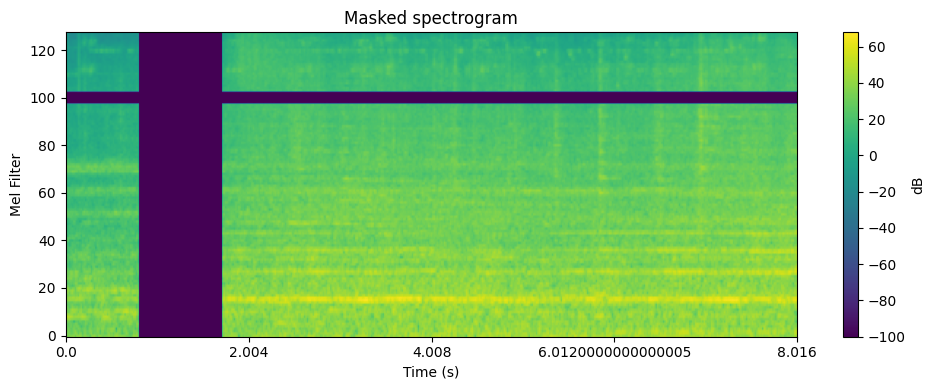

torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


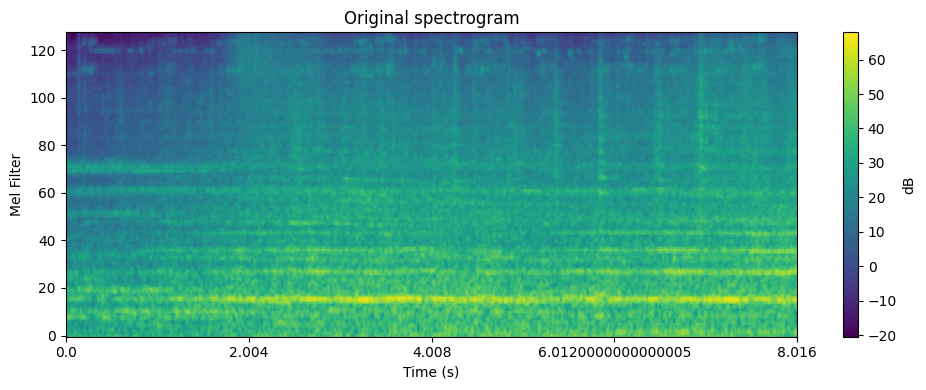

In [9]:
data1, data2 = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")

In [11]:
train_loader, val_loader = DL.create_generators()
# Instantiate model, loss function, and optimizer
#model = Autoencoder()
#model = Autoencoder2deeper()
#model = Autoencoder2deeperDO()
model = ResNetAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Training loop
num_epochs = 50



Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True


In [12]:

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for mel_spec_masked, mel_spec in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        mel_spec_masked = mel_spec_masked.to(device)
        mel_spec = mel_spec.to(device)

        optimizer.zero_grad()

        outputs = model(mel_spec_masked)
        _, _, H, W = outputs.size()
        mel_spec = mel_spec[..., :H, :W]

        loss = criterion(outputs, mel_spec)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_spec_masked, mel_spec in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            mel_spec_masked = mel_spec_masked.to(device)
            mel_spec = mel_spec.to(device)

            outputs = model(mel_spec_masked)
            _, _, H, W = outputs.size()
            mel_spec = mel_spec[..., :H, :W]

            loss = criterion(outputs, mel_spec)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # Print losses
    print(f'Epoch {epoch+1}, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}')


Epoch 1/50 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


Epoch 1, Average Train Loss: 133.5493, Average Val Loss: 120.9808


Epoch 2/50 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Epoch 2, Average Train Loss: 125.1997, Average Val Loss: 125.1611


Epoch 3/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]


Epoch 3, Average Train Loss: 123.3841, Average Val Loss: 120.9675


Epoch 4/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]


Epoch 4, Average Train Loss: 122.5288, Average Val Loss: 120.4011


Epoch 5/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.05it/s]


Epoch 5, Average Train Loss: 121.4197, Average Val Loss: 118.0404


Epoch 6/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]


Epoch 6, Average Train Loss: 120.8825, Average Val Loss: 118.6690


Epoch 7/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.05it/s]


Epoch 7, Average Train Loss: 119.5826, Average Val Loss: 117.1359


Epoch 8/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.04it/s]


Epoch 8, Average Train Loss: 119.7039, Average Val Loss: 115.2478


Epoch 9/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.05it/s]


Epoch 9, Average Train Loss: 118.6269, Average Val Loss: 115.9742


Epoch 10/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]


Epoch 10, Average Train Loss: 118.5851, Average Val Loss: 117.9714


Epoch 11/50 - Validation: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Epoch 11, Average Train Loss: 118.8349, Average Val Loss: 114.9427


Epoch 12/50 - Validation: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 12, Average Train Loss: 118.3417, Average Val Loss: 116.7039


Epoch 13/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]


Epoch 13, Average Train Loss: 118.0623, Average Val Loss: 117.3598


Epoch 14/50 - Validation: 100%|██████████| 70/70 [00:33<00:00,  2.06it/s]


Epoch 14, Average Train Loss: 117.7525, Average Val Loss: 114.3488


Epoch 15/50 - Validation: 100%|██████████| 70/70 [00:34<00:00,  2.06it/s]


Epoch 15, Average Train Loss: 118.0717, Average Val Loss: 114.3025


Epoch 16/50 - Validation: 100%|██████████| 70/70 [00:38<00:00,  1.83it/s]


Epoch 16, Average Train Loss: 117.7636, Average Val Loss: 116.1376


Epoch 17/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]


Epoch 17, Average Train Loss: 117.7639, Average Val Loss: 114.1862


Epoch 18/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]


Epoch 18, Average Train Loss: 117.2639, Average Val Loss: 116.3709


Epoch 19/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.86it/s]


Epoch 19, Average Train Loss: 117.7694, Average Val Loss: 113.8089


Epoch 20/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.84it/s]


Epoch 20, Average Train Loss: 117.1818, Average Val Loss: 113.7929


Epoch 21/50 - Validation: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]


Epoch 21, Average Train Loss: 117.2931, Average Val Loss: 113.6254


Epoch 22/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.84it/s]


Epoch 22, Average Train Loss: 117.2663, Average Val Loss: 113.9082


Epoch 23/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.89it/s]


Epoch 23, Average Train Loss: 117.4019, Average Val Loss: 115.6994


Epoch 24/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]


Epoch 24, Average Train Loss: 116.8991, Average Val Loss: 116.7570


Epoch 25/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.87it/s]


Epoch 25, Average Train Loss: 116.8131, Average Val Loss: 115.6313


Epoch 26/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.89it/s]


Epoch 26, Average Train Loss: 116.8594, Average Val Loss: 115.6649


Epoch 27/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.89it/s]


Epoch 27, Average Train Loss: 116.6638, Average Val Loss: 114.4623


Epoch 28/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]


Epoch 28, Average Train Loss: 116.6133, Average Val Loss: 115.2988


Epoch 29/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]


Epoch 29, Average Train Loss: 116.5045, Average Val Loss: 113.3503


Epoch 30/50 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Epoch 30, Average Train Loss: 116.5216, Average Val Loss: 116.9719


Epoch 31/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]


Epoch 31, Average Train Loss: 116.4871, Average Val Loss: 114.6109


Epoch 32/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]


Epoch 32, Average Train Loss: 116.3821, Average Val Loss: 116.3145


Epoch 33/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]


Epoch 33, Average Train Loss: 116.3369, Average Val Loss: 112.9809


Epoch 34/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]


Epoch 34, Average Train Loss: 116.5604, Average Val Loss: 113.2351


Epoch 35/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]


Epoch 35, Average Train Loss: 116.2151, Average Val Loss: 115.4558


Epoch 36/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]


Epoch 36, Average Train Loss: 116.1723, Average Val Loss: 112.8396


Epoch 37/50 - Validation: 100%|██████████| 70/70 [00:35<00:00,  1.95it/s]


Epoch 37, Average Train Loss: 116.1191, Average Val Loss: 113.9203


Epoch 38/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.92it/s]


Epoch 38, Average Train Loss: 116.2783, Average Val Loss: 114.8198


Epoch 39/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]


Epoch 39, Average Train Loss: 116.1257, Average Val Loss: 115.6296


Epoch 40/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]


Epoch 40, Average Train Loss: 116.1521, Average Val Loss: 113.0704


Epoch 41/50 - Validation: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]


Epoch 41, Average Train Loss: 116.1866, Average Val Loss: 114.8354


Epoch 42/50 - Validation: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


Epoch 42, Average Train Loss: 115.9234, Average Val Loss: 113.6446


Epoch 43/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]


Epoch 43, Average Train Loss: 115.9288, Average Val Loss: 112.6956


Epoch 44/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.88it/s]


Epoch 44, Average Train Loss: 116.0238, Average Val Loss: 113.0165


Epoch 45/50 - Validation: 100%|██████████| 70/70 [00:38<00:00,  1.84it/s]


Epoch 45, Average Train Loss: 115.9538, Average Val Loss: 114.6456


Epoch 46/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.86it/s]


Epoch 46, Average Train Loss: 115.9338, Average Val Loss: 113.1135


Epoch 47/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.88it/s]


Epoch 47, Average Train Loss: 116.0678, Average Val Loss: 112.6800


Epoch 48/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]


Epoch 48, Average Train Loss: 115.7976, Average Val Loss: 112.8936


Epoch 49/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]


Epoch 49, Average Train Loss: 115.7867, Average Val Loss: 114.1620


Epoch 50/50 - Validation: 100%|██████████| 70/70 [00:37<00:00,  1.85it/s]

Epoch 50, Average Train Loss: 115.8423, Average Val Loss: 112.3861


In [13]:
#save whole model
torch.save(model, './results/res_auto/resNet2_autoen_model.pth')

torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


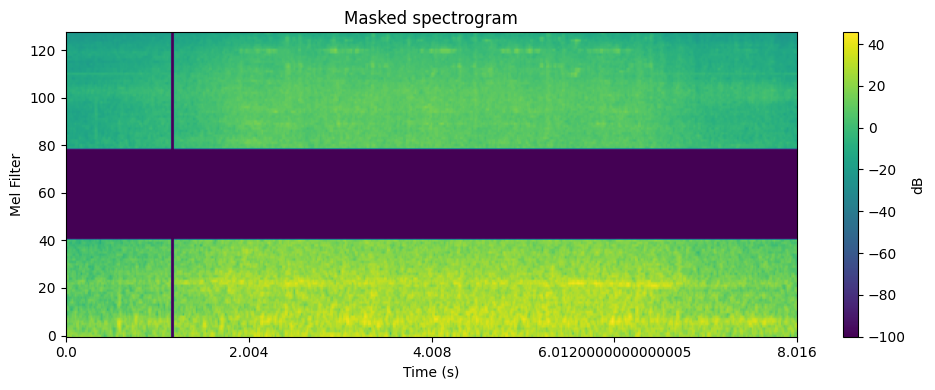

torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


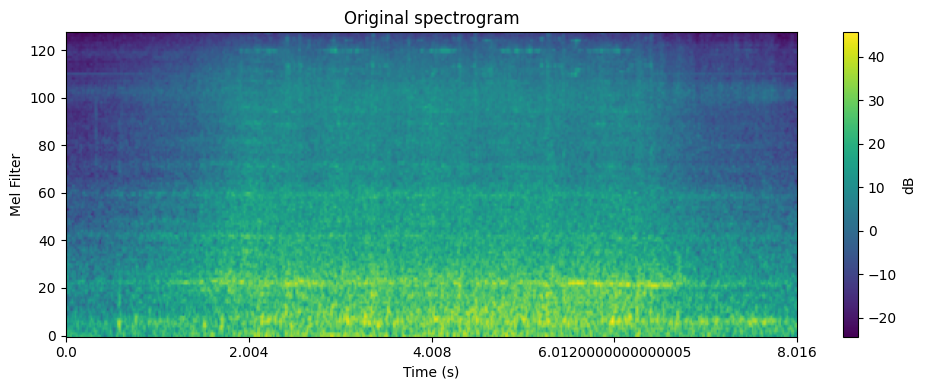

torch.Size([128, 501])
torch.Size([64, 3, 128, 501])


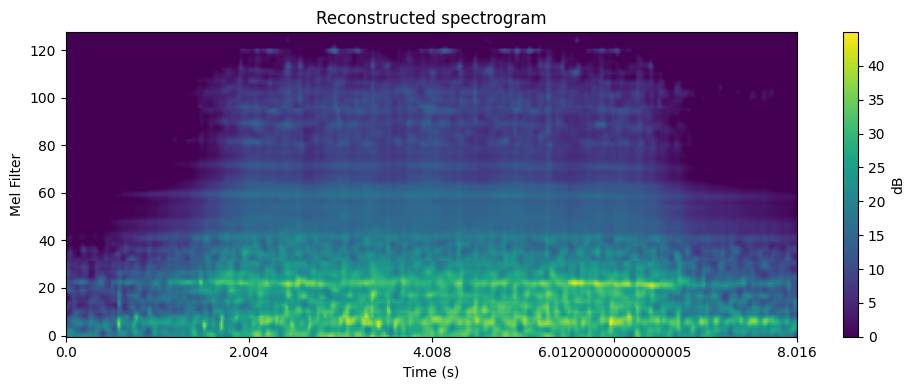

In [28]:
data1, data2 = next(iter(train_loader))
outputs = model(data1.to(device))


plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")
plot_mel_spectrogram(outputs, sample_rate=32000, hop_length=512,name="Reconstructed spectrogram")

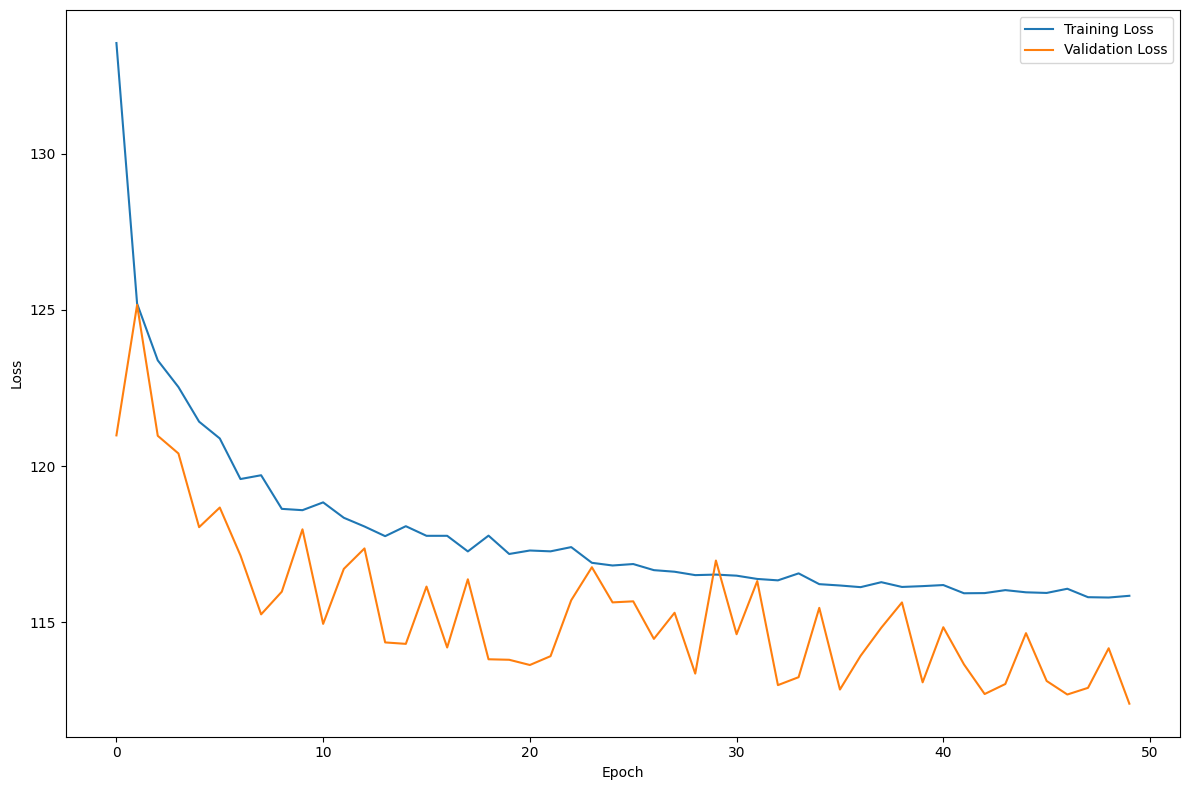

In [23]:
#plot loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
